## Description
Given Claude Monet's paints in the form of tfrec and jpg file, use GANs(generative adversarial networks) algorithm to create the master style paintings.

In [1]:
# Some code is based off of the recommended starter notebook from Amy Jang: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Conv2D, Conv2DTranspose, UpSampling2D, Dropout, Activation, Concatenate
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tensorflow.keras import backend as K
import glob


## Data Brief

In [2]:
monet_jpg_folder_path= 'monet_jpg'
monet_tfrec_folder_path = 'monet_tfrec'
photo_jpg_folder_path = 'photo_jpg'
photo_tfrec_folder_path = 'photo_tfrec'

## Show file numbers in each folder

In [3]:
data_list = [monet_jpg_folder_path,monet_tfrec_folder_path,photo_jpg_folder_path,photo_tfrec_folder_path]

for d in data_list:
    img = glob.glob(d + '/*.*')
    print(d,'file numbers: ',len(img))

monet_jpg file numbers:  300
monet_tfrec file numbers:  5
photo_jpg file numbers:  7038
photo_tfrec file numbers:  20


##  Start with tfrec folders

In [4]:
Monet_Filenames = glob.glob(monet_tfrec_folder_path + '/*.tfrec')
Photo_Filenames = glob.glob(photo_tfrec_folder_path + '/*.tfrec')
print('Monet_TFRecord_Files: ', len(Monet_Filenames))
print('Photo_TFRecord_Files: ', len(Photo_Filenames))

Monet_TFRecord_Files:  5
Photo_TFRecord_Files:  20


## Display all features in single tfrec file

In [5]:
raw_datasets = tf.data.TFRecordDataset(Monet_Filenames)
raw_datasets

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [27]:
for raw_record in raw_datasets.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)


features {
  feature {
    key: "target"
    value {
      bytes_list {
        value: "monet"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\000\001\000\003\001\021\000\002\021\001\003\021\001\377\304\000\036\000\000\002\002\003\001\001\001\001\000\000\000\000\000\000\000\000\006\007\004\005\003\010\t\002\000\n\001\377\304\000K\020\000\002\001\002\004\003\005\005\004\t\003\001\007\001\t\000\003\004\005\006\023\000\002\007#\0243C\010\022\025Sc\

In [7]:
Image_Size = [256,256]
Channel = 3

def decode_image(image):
    image = tf.image.decode_jpeg(image,channels=Channel)
    image = (tf.cast(image,tf.float32)/127.5) - 1
    image = tf.reshape(image,[*Image_Size,3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([],tf.string),
        "image":tf.io.FixedLenFeature([],tf.string),
        "target":tf.io.FixedLenFeature([],tf.string)
    }
    example = tf.io.parse_single_example(example,tfrecord_format)
    image = decode_image(example['image'])
    
    return image

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def load_dataset(filenames, labeled=True,ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord,num_parallel_calls=AUTOTUNE)
    return dataset

## Load datasets

In [9]:
monet_ds = load_dataset(Monet_Filenames,labeled=True).batch(1)
photo_ds = load_dataset(Photo_Filenames,labeled=True).batch(1)
print(monet_ds)


<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


In [10]:
# example_monet = next(iter(monet_ds))
example_monet = iter(monet_ds)
# example_photo = next(iter(photo_ds))
example_photo = iter(photo_ds)
# print(example_monet)

## Show sample of the paints and photos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


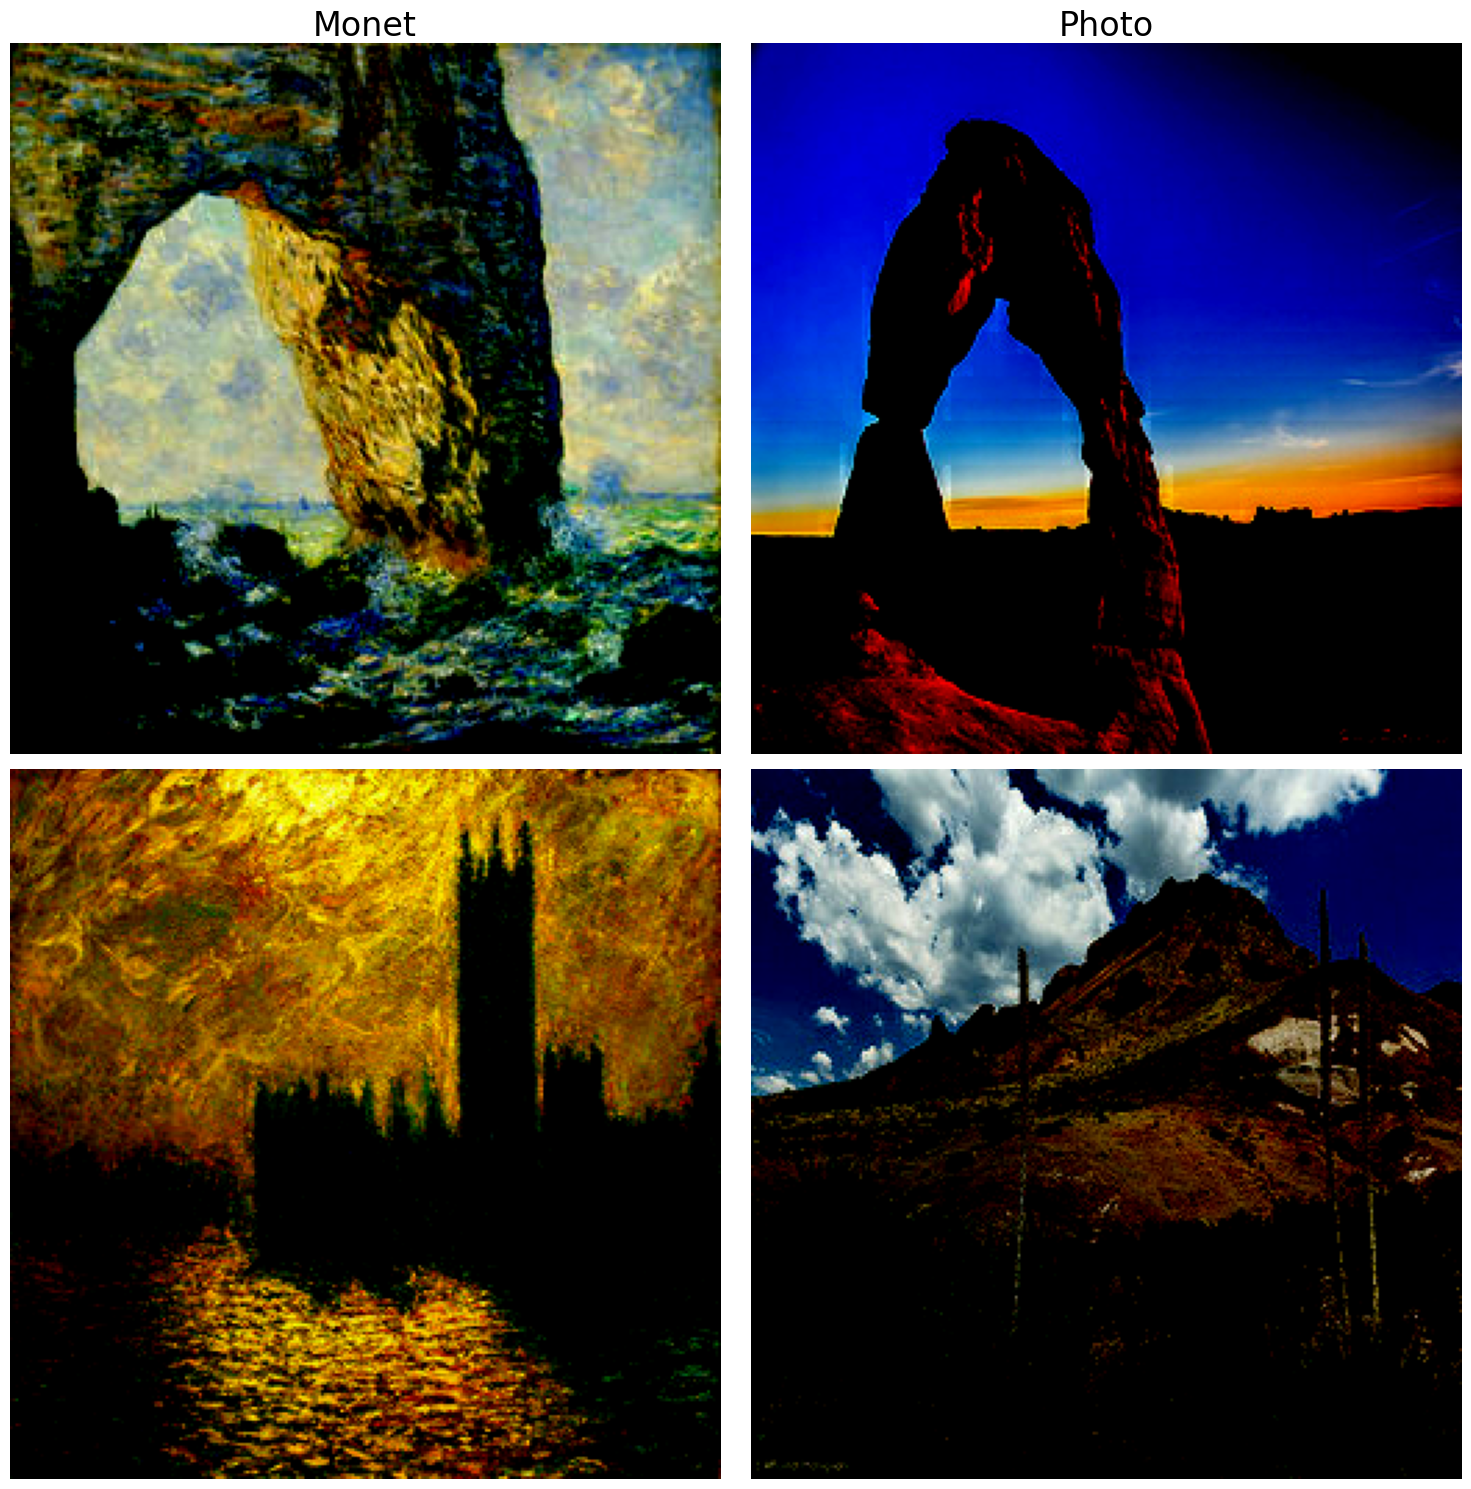

In [11]:
fig,axs = plt.subplots(2,2,figsize=(15,15))

axs[0,0].imshow(next(example_monet)[0])
axs[0,1].imshow(next(example_photo)[0])
axs[1,0].imshow(next(example_monet)[0])
axs[1,1].imshow(next(example_photo)[0])
axs[0,0].set_title(f'Monet',fontsize=24)
axs[0,1].set_title('Photo',fontsize=24)

for ax in axs.ravel():
    ax.set_axis_off()

fig.tight_layout()

## Display color distribution from paints and photos

looks photos diagrams more centerialized in shape than paints

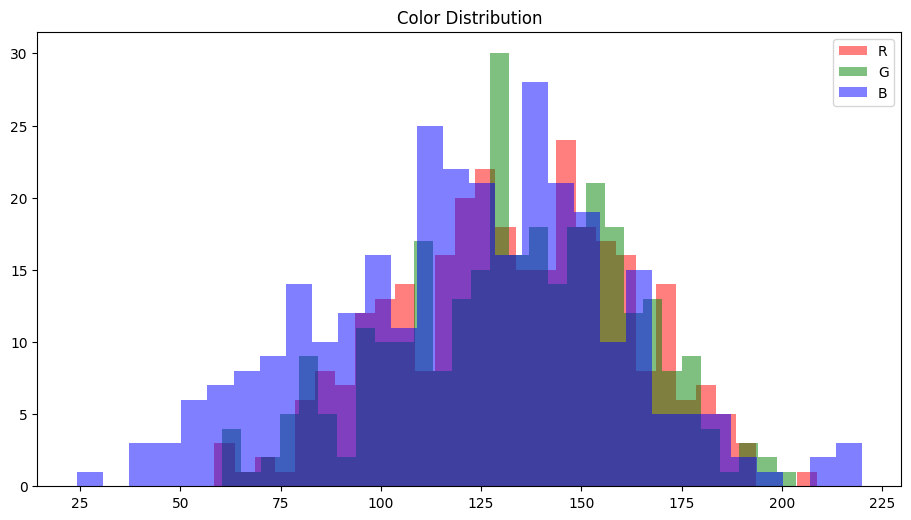

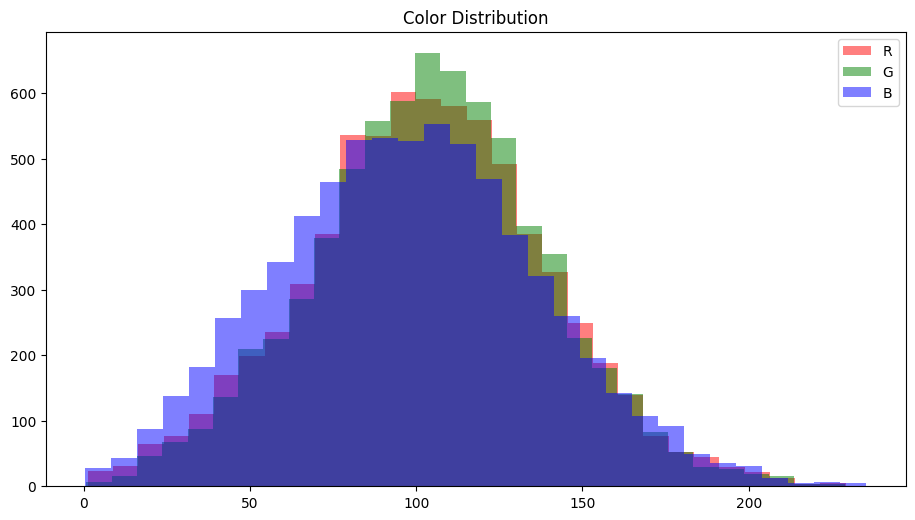

In [12]:
def analyze_images(directory):
    files = [f for f in os.listdir(directory) if f.lower().endswith(('jpg'))]
    color_distributions = []

    for file_name in files:
        file_path = os.path.join(directory, file_name)
        with Image.open(file_path) as img:
            color_distributions.append(np.array(img).mean(axis=(0, 1)))

    return color_distributions

def plot_analysis(color_distributions):    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 2, 1)
    color_distributions = np.array(color_distributions)
    if color_distributions.ndim == 2:
        plt.hist(color_distributions[:, 0], bins=30, color='red', alpha=0.5, label='R')
        plt.hist(color_distributions[:, 1], bins=30, color='green', alpha=0.5, label='G')
        plt.hist(color_distributions[:, 2], bins=30, color='blue', alpha=0.5, label='B')
        plt.legend()
        plt.title('Color Distribution')
    else:
        plt.hist(color_distributions, bins=30, color='gray', alpha=0.7)
        plt.title('Gray-scale Distribution')

    plt.tight_layout()
    plt.show()

color_distributions = analyze_images(monet_jpg_folder_path)
plot_analysis(color_distributions)

color_distributions = analyze_images(photo_jpg_folder_path)
plot_analysis(color_distributions)

## Modeling GANs

Build the generator

In [13]:
def downsample(filters,size,apply_norm=True):
    initial = tf.random_normal_initializer(0.,0.02)
    result = models.Sequential()
    result.add(Conv2D(filters,size,strides=2,padding='same',kernel_initializer=initial,use_bias=False))
    if apply_norm:
        result.add(layers.GroupNormalization(groups=-1))
    result.add(LeakyReLU())
    return result

In [14]:
def upsample(filters,size,apply_dropout=False):
    initial = tf.random_normal_initializer(0.,0.02)
    result = models.Sequential()
    result.add(Conv2DTranspose(filters,size,strides=2,padding='same',kernel_initializer=initial,use_bias=False))
    # result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
    #                                   use_bias=False))
    result.add(layers.GroupNormalization(groups=-1))
    if apply_dropout:
        result.add(Dropout(0.4))
    result.add(LeakyReLU())
    return result

In [15]:
def build_generator():
    inputs = Input(shape=(Image_Size[0],Image_Size[1],Channel))

    down_pack = [
        downsample(64,4,apply_norm=False),
        downsample(128,4),
        downsample(256,4),
        downsample(512,4)
    ]

    up_pack = [
        upsample(512,4,apply_dropout=True),
        upsample(258,4,apply_dropout=True),
        upsample(128,4,apply_dropout=True),
        upsample(64,4,apply_dropout=True)
    ]

    initial = tf.random_normal_initializer(0.,0.02)
    out = Conv2DTranspose(3,4,strides=2,padding='same',kernel_initializer=initial,activation='tanh')

    x = inputs
    skip = []
    for dw in down_pack:
        x = dw(x)
        skip.append(x)
    
    skip = reversed(skip[:-1])

    for up, sk in zip(up_pack,skip):
        x = up(x)
        x = Concatenate()([x,sk])

    x = out(x)
    return Model(inputs,x)

Build discriminator

In [16]:
def build_discriminator():
    initial = tf.random_normal_initializer(0.,0.02)
    inputs = Input(shape=(Image_Size[0],Image_Size[1],Channel),name='input_image')

    x = inputs
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
    x = downsample(512,4)(x)
    x = Flatten()(x)
    x = Dense(1,activation='sigmoid')(x)
    return Model(inputs,x)

In [17]:
monet_gen = build_generator()
photo_gen = build_generator()
monet_dis = build_discriminator()
photo_dis = build_discriminator()

Define the loss and optimizers

In [18]:
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [19]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss+fake_loss
    return total_loss*0.5

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [21]:
LAM = 10

def compute_cycle_loss(real_img,cycled_img):
    loss = tf.reduce_mean(tf.abs(real_img-cycled_img))
    return LAM*loss

In [22]:
def identity_loss(real_img,same_img):
    loss = tf.reduce_mean(tf.abs(real_img-same_img))
    return LAM*0.5*loss

In [23]:
# Optimizer
monet_gen_optimizer = Adam(2e-4,beta_1=0.5)
photo_gen_optimizer = Adam(2e-4,beta_1=0.5)
monet_disc_optimizer= Adam(2e-4,beta_1=0.5)
photo_disc_optimizer= Adam(2e-4,beta_1=0.5)

Checkpoints

In [24]:
CHECKPOINT_DIR = 'checkpoints/train'

ckpt = tf.train.Checkpoint(monet_generator=monet_gen,
                           photo_generator=photo_gen,
                           monet_discriminator=monet_dis,
                           photo_discriminator=photo_dis,
                           monet_generator_optimizer=monet_gen_optimizer,
                           photo_generator_optimizer=photo_gen_optimizer,
                           monet_discriminator_optimizer=monet_disc_optimizer,
                           photo_discriminator_optimizer=photo_disc_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_DIR, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

In [25]:
@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # real monet -> fake photo
        fake_photo = monet_gen(real_monet, training=True)
        # fake photo -> monet
        cycled_monet = photo_gen(fake_photo, training=True)
        # real photo -> fake monet
        fake_monet = photo_gen(real_photo, training=True)
        # fake monet -> photo
        cycled_photo = monet_gen(fake_monet, training=True)
        # use for identity loss
        same_monet = monet_gen(real_monet, training=True)
        same_photo = photo_gen(real_photo, training=True)
        
        # The discriminators evaluate both real and fake images in each domain
        disc_real_monet = monet_dis(real_monet, training=True)
        disc_real_photo = photo_dis(real_photo, training=True)
        disc_fake_monet = monet_dis(fake_monet, training=True)
        disc_fake_photo = photo_dis(fake_photo, training=True)
        
        # Generator losses: How well the generators fool the discriminators
        monet_gen_loss = generator_loss(disc_fake_photo)
        photo_gen_loss = generator_loss(disc_fake_monet)
        # Cycle consistency loss: Ensures that cycled images are similar to originals
        total_cycle_loss = compute_cycle_loss(real_monet, cycled_monet) + compute_cycle_loss(real_photo, cycled_photo)
        # Identity loss: Encourages generators to preserve input when it's already in the target domain
        total_monet_gen_loss = monet_gen_loss + total_cycle_loss + identity_loss(real_monet, same_monet)
        total_photo_gen_loss = photo_gen_loss + total_cycle_loss + identity_loss(real_photo, same_photo)
        # Discriminator losses: How well the discriminators distinguish real from fake images
        monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
    
    # Computes the gradients for each model with respect to its loss.
    monet_generator_gradients = tape.gradient(total_monet_gen_loss, monet_gen.trainable_variables)
    photo_generator_gradients = tape.gradient(total_photo_gen_loss, photo_gen.trainable_variables)
    monet_discriminator_gradients = tape.gradient(monet_disc_loss, monet_dis.trainable_variables)
    photo_discriminator_gradients = tape.gradient(photo_disc_loss, photo_dis.trainable_variables)
    
    # Updates the model parameters using the calculated gradients.
    monet_gen_optimizer.apply_gradients(zip(monet_generator_gradients, monet_gen.trainable_variables))
    photo_gen_optimizer.apply_gradients(zip(photo_generator_gradients, photo_gen.trainable_variables))
    monet_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, monet_dis.trainable_variables))
    photo_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, photo_dis.trainable_variables))

In [29]:
from IPython.display import clear_output
import time

def train(monet_dataset,photo_dataset,epochs):
    n=0
    for ep in range(epochs):
        start = time.time()
        for monet,photo in tf.data.Dataset.zip(monet_dataset,photo_dataset):
            train_step(monet,photo)
            if n%10==0:
                print('.',end='')
            n+=1
        clear_output(wait=True)
        if (ep+1)%5 ==0:
            ckpt_save_path = ckpt_manager.save()
            print('saving checkpoint for epoch {} at {}'.format(ep+1,ckpt_save_path))
        
        print(f'time for epoch {ep+1} is {time.time()-start} sec')

In [30]:
def generate_images(model,test_input):
    pred = model(test_input)
    plt.figure(figsize=(10,10))
    display_list = [test_input[0],pred[0]]
    title = ['Input_image','Fake_style_image']
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5)
        plt.axis('off')
    plt.show()

## Train model

In [31]:
train(monet_ds,photo_ds,epochs=10)

saving checkpoint for epoch 10 at checkpoints/train/ckpt-2
time for epoch 10 is 3333.82323884964 sec


## Generate Images

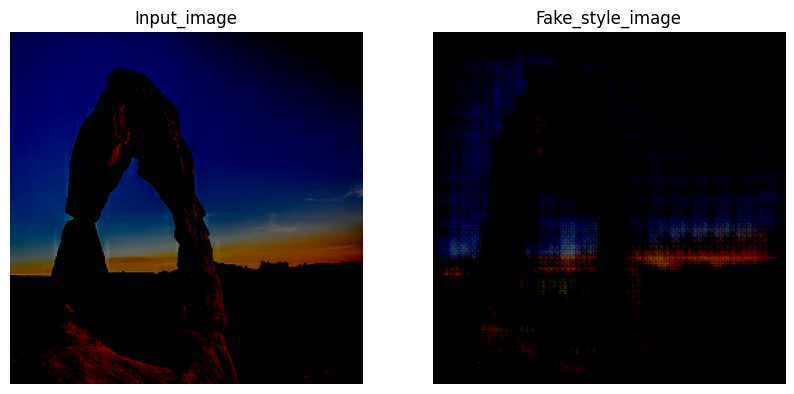

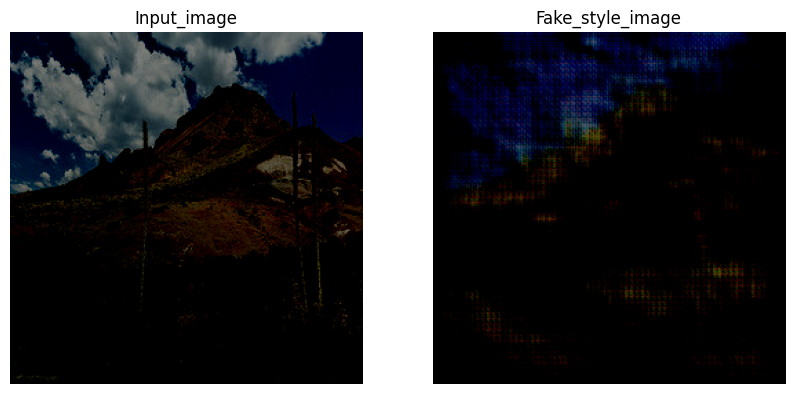

In [35]:
for photo in photo_ds.take(2):
    generate_images(monet_gen,photo)

## Submission

In [37]:
from os import mkdir
mkdir('images')

In [44]:
import shutil

i = 1
for photo in photo_ds:
    if i<=1000:
        prediction = monet_gen(photo,training=False)[0].numpy()
        prediction =(prediction*127.5+127.5).astype(np.uint8)
        im = Image.fromarray(prediction)
        im.save('images/'+str(i)+'.jpg')
        i+=1
    else:
        break

shutil.make_archive("images","zip","images/")

'/Users/jms/Desktop/cbu_mscs/Intr_Deep_Learning/week5_unsupervised_DL/Monet_GANs/images.zip'

## Conclusion

tried GANs on making Monet style pictures, not quite success on either algorithm structure or training epoches(hardware limit..,my personal computer is too slow for training).the outputs is just looks fuzzy than photoes, anyway, it's a good try to see the how it goes.